# **Русско-английский переводчик с использованием трансформера**

Однажды я заметила, что переводчик некорректно работает с длинными текстами, хотя я не была уверена, что это типично для всех длинных текстов, но интуитивно я вводила короткие предложения в Google Translate. Теперь я понимаю, почему это было так - это все из-за RNN. С 2017 года Google Translate перешел на архитектуру трансформеров, поэтому переводы стали лучше. Я решила разобраться в том как они работают и рассмотрела следующее руководство: **https://keras.io/examples/nlp/neural_machine_translation_with_transformer/.**

**Сначала подключим необходимые библиотеки**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import plot_model
from google.colab import data_table

**БД переводов я взяла с Anki (https://www.manythings.org/anki/) и сделала следующий датафрейм:**

In [ ]:
en_rus_df = pd.read_csv('rus.txt', sep='\t', usecols=[0, 1])
en_rus_df.columns = ['en', 'rus']
en_rus_df.head()

,en,rus
0,Go.,Иди.
1,Go.,Идите.
2,Hi.,Здравствуйте.
3,Hi.,Привет!
4,Hi.,Хай.


In [ ]:
print("Размер датафрейма: ", en_rus_df.shape)

Размер датафрейма:  (438014, 2)


**Данная модель является упрощенной, поэтому приводим тексты в нижний регистр и убираем пунктуацию. Для текстов на английском переписываем сокращения в формальном виде (официальном виде):**

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def clean_text(text, language):
  text = text.lower() # приводим в нижний регистр
  if language == 'en':
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()]) # приводим к формальному стилю английский текст
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # убираем пунктуацию
  return text

for language in en_rus_df:
  en_rus_df[language] = en_rus_df[language].apply(lambda text : clean_text(text, language))

en_rus_df.head()

,en,rus
0,go,иди
1,go,идите
2,hi,здравствуйте
3,hi,привет
4,hi,хай


**Таким датасет оставлять тоже нельзя, так как для перевода текста требует чтобы у целевого текста (в нашем случае английского) были токены начала и конца, поэтому добавим их.**

In [ ]:
en_rus_df['en'] = en_rus_df['en'].apply(lambda i : "[start] " + i + "[end]")

In [ ]:
en_rus_df.head()

,en,rus
0,[start] go [end],иди
1,[start] go [end],идите
2,[start] hi [end],здравствуйте
3,[start] hi [end],привет
4,[start] hi [end],хай


**Определим распределение длин текстов**


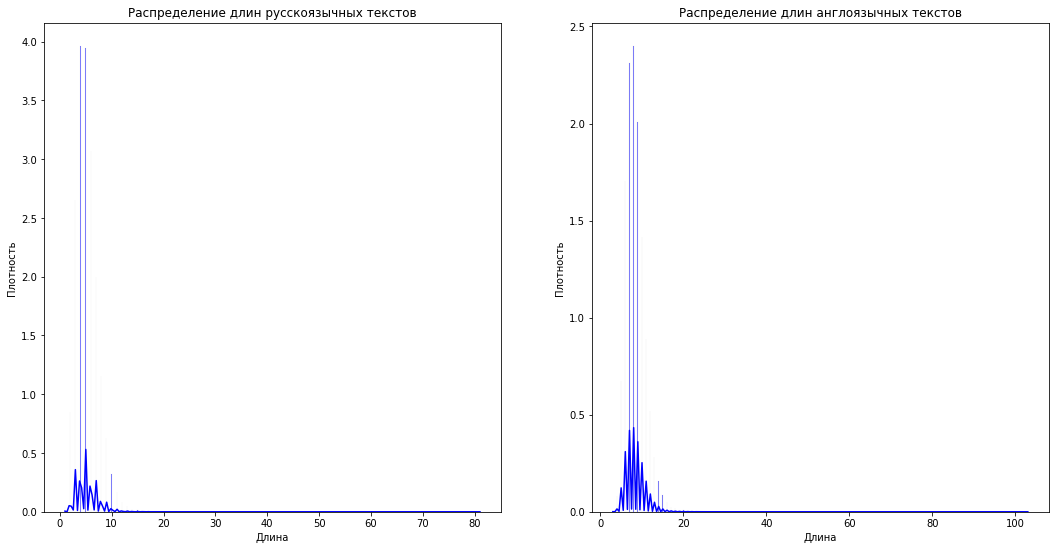

In [ ]:
plt.figure(figsize=(18, 9))
plt.subplot(121)
sns.histplot(en_rus_df['rus'].str.split().apply(len), color="blue", kde=True, stat="density")
plt.title('Распределение длин русскоязычных текстов')
plt.xlabel('Длина')
plt.ylabel('Плотность')

plt.subplot(122)
sns.histplot(en_rus_df['en'].str.split().apply(len), color="blue", kde=True, stat="density")
plt.title('Распределение длин англоязычных текстов')
plt.xlabel('Длина')
plt.ylabel('Плотность')
plt.show()

Из графиков видно, что достаточно ограничиться текстами длиной до 20 слов

In [ ]:
seq_len = 20

**Разбиваем данные на тренировочные, валидационные и тестовые выборки**

In [ ]:
train_df, test_df = train_test_split(en_rus_df, test_size=0.2, shuffle=True, random_state=100)

train_df = train_df.reset_index(drop=True)

val_df, test_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=100)

test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Размер тренировочного датафрейма:", train_df.shape)
print("Размер тестового датафрейма:", test_df.shape)
print("Размер валидационного датафрейма:", val_df.shape)

Размер тренировочного датафрейма: (350411, 2)
Размер тестового датафрейма: (43802, 2)
Размер валидационного датафрейма: (43801, 2)


In [ ]:
test_df.head()

,en,rus
0,[start] i got it for free [end],я получил это бесплатно
1,[start] do not tell tom that [end],не говорите об этом тому
2,[start] i am glad to hear you say that [end],я рада слышать что вы говорите это
3,[start] get me the evidence [end],приведи улики
4,[start] how much does this shirt cost [end],сколько стоит эта рубашка


**Делаем словарь**

In [ ]:
en_rus_list = list(en_rus_df.to_records(index=False)) # представляем en_rus_df как list of tuples

In [ ]:
en_rus_list[:5]

[('[start] go [end]', 'иди '),
 ('[start] go [end]', 'идите '),
 ('[start] hi [end]', 'здравствуйте '),
 ('[start] hi [end]', 'привет '),
 ('[start] hi [end]', 'хай ')]

In [ ]:
vocab_size = 15000 # пусть будет так
batch_size = 64 # пусть будет так

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
  return tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")

rus_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=seq_len,)

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq_len + 1,
    standardize=custom_standardization,)

train_rus_texts = [pair[1] for pair in en_rus_list]
train_eng_texts = [pair[0] for pair in en_rus_list]
rus_vectorization.adapt(train_rus_texts)
eng_vectorization.adapt(train_eng_texts)

In [ ]:
rus_vocabulary = rus_vectorization.get_vocabulary()
print("Первые 5 токенов русского словаря: ", rus_vocabulary[:5])

Первые 5 токенов русского словаря:  ['', '[UNK]', 'я', 'не', 'том']


In [ ]:
eng_vocabulary = eng_vectorization.get_vocabulary()
print("Первые 5 токенов английского словаря: ", eng_vocabulary[:5])

Первые 5 токенов английского словаря:  ['', '[UNK]', '[start]', '[end]', 'i']


**Для применения архитектуры трансформера нам нужно представить тренировочные и тестовые датафреймы в виде датасетов Tensorflow (https://www.tensorflow.org/api_docs/python/tf/data/Dataset)**

In [ ]:
train_list = list(train_df.to_records(index=False)) # представляем train_df как list of tuples
test_list = list(test_df.to_records(index=False)) # представляем test_df как list of tuples
val_list = list(val_df.to_records(index=False)) # представляем val_df как list of tuples

In [ ]:
test_list[:5]

[('[start] i got it for free [end]', 'я получил это бесплатно '),
 ('[start] do not tell tom that [end]', 'не говорите об этом тому '),
 ('[start] i am glad to hear you say that [end]', 'я рада слышать  что вы говорите это '),
 ('[start] get me the evidence [end]', 'приведи улики '),
 ('[start] how much does this shirt cost [end]', 'сколько стоит эта рубашка ')]

In [ ]:
def format_dataset(eng, rus):
    eng = eng_vectorization(eng)
    rus = rus_vectorization(rus)
    return ({"encoder_inputs": rus, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])


def make_dataset(pairs):
    eng_texts, rus_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    rus_texts = list(rus_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_list)
test_ds = make_dataset(test_list)
val_ds = make_dataset(val_list)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


**Вспомним что такое трансформер и приступим к созданию модели**

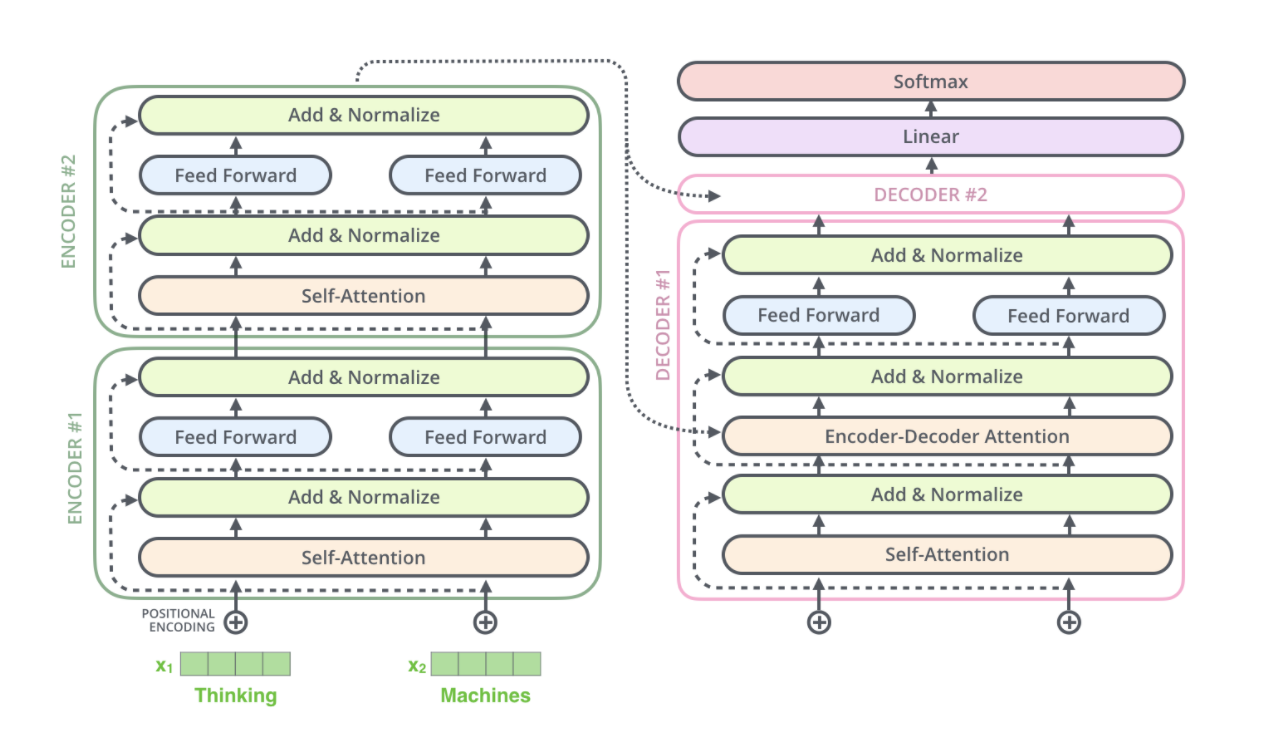

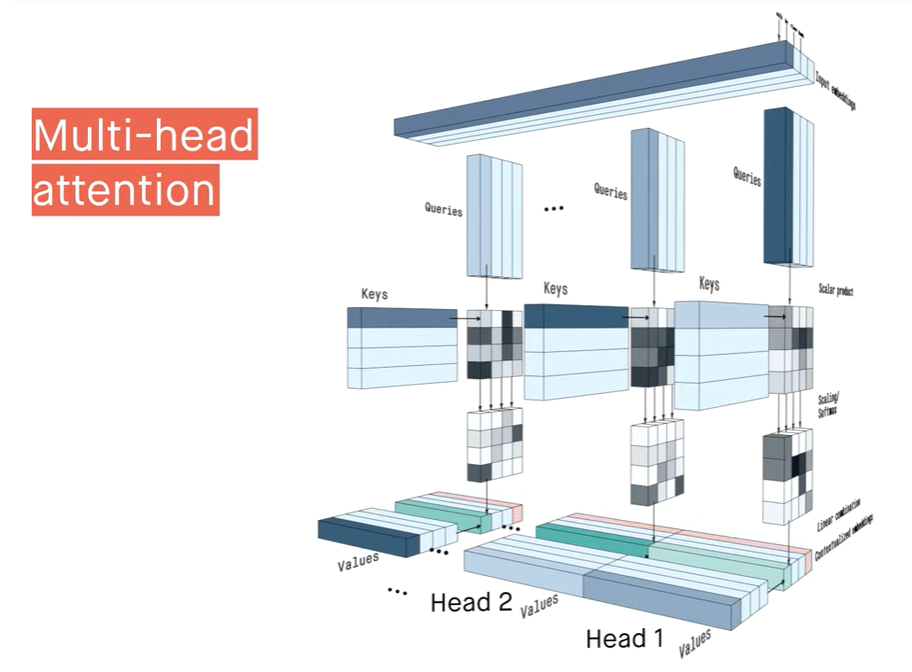

**Полезные ссылки:**
1. https://jalammar.github.io/illustrated-transformer/
2. https://keras.io/examples/nlp/neural_machine_translation_with_transformer/
3. https://www.youtube.com/watch?v=-9vVhYEXeyQ
4. https://www.youtube.com/watch?v=rBCqOTEfxvg

**Интересная ссылка:** https://nlpprogress.com/english/language_modeling.html

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim # размер еmbedding-а
        self.dense_dim = dense_dim # количество нейронов 
        self.num_heads = num_heads # количество голов (слоев) в MultiHeadAttention 
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs) # маска, которая закрывает будущее в attention_1
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0,)
        return tf.tile(mask, mult)

**Вызываем функции и тренируем модель:**

In [ ]:
embed_dim = 256
latent_dim = 2048 # количество нейронов для Dense слоев Encoder-а и Decoder-а
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x) # первый Encoder
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs) # первый Decoder
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

In [ ]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile("rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # RMSProp vs Adam
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
plot_model(transformer, to_file = 'transformer_model.jpg', show_shapes=True)

**Проверяем работу построенного трансформера:**

In [ ]:
eng_index_lookup = dict(zip(range(len(eng_vocabulary)), eng_vocabulary))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = rus_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = eng_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

**Результаты на тренировочной выборке:**

In [ ]:
results_on_train = []
for _ in range(10):
    input_sentence = random.choice(train_list)
    test_rus_texts = input_sentence[1]
    test_eng_texts = input_sentence[0]
    translated = decode_sequence(test_rus_texts)
    results_on_train.append({'rus': test_rus_texts, 'en': translated, 'en_target': test_eng_texts})

results_on_train_df = pd.DataFrame(results_on_train)
results_on_train_table = data_table.DataTable(results_on_train_df, include_index=False, num_rows_per_page=10)
results_on_train_table

,rus,en,en_target
0,том идёт с нами,[start] is tom coming with us [end],[start] is tom coming with us [end]
1,я знаю его по виду но не по имени,[start] i know him by what he is not the name ...,[start] i know him by sight but not by name [...
2,я была очень счастлива,[start] i was really happy [end],[start] i was very happy [end]
3,теперь с тобой будет всё в порядке,[start] you are now [end],[start] you will be fine now [end]
4,делать это было бы слишком рискованно,[start] doing that would be too i get is too i...,[start] doing that would be too risky [end]
5,красивая рубашка,[start] that is a nice shirt [end],[start] that is a nice shirt [end]
6,не думаю что том потерялся,[start] i do not think that tom is lost [end],[start] i do not think tom is lost [end]
7,что то вот вот произойдёт,[start] something s about to happen [end],[start] something s about to happen [end]
8,я был достаточно вежлив,[start] i was pretty enough [end],[start] was i polite enough [end]
9,что ты хотел спросить у меня,[start] what did you mean to ask me [end],[start] what did you want to ask me [end]


**Результаты на тестовой выборке:**

In [ ]:
results_on_test = []
for _ in range(10):
    input_sentence = random.choice(test_list)
    test_rus_texts = input_sentence[1]
    test_eng_texts = input_sentence[0]
    translated = decode_sequence(test_rus_texts)
    results_on_test.append({'rus': test_rus_texts, 'en': translated, 'en_target': test_eng_texts})

results_on_test_df = pd.DataFrame(results_on_test)
results_on_test_table = data_table.DataTable(results_on_test_df, include_index=False, num_rows_per_page=10)
results_on_test_table

,rus,en,en_target
0,тебе надо быть осторожным,[start] you have to be careful [end],[start] you have got to be careful [end]
1,теперь вы можете идти если хотите,[start] you can go now if you want to [end],[start] you can go now if you wish [end]
2,с кем том хочет поехать в австралию,[start] who does tom want to go to australia w...,[start] who does tom want to go to australia w...
3,что они пытаются мне сказать,[start] what are they trying to tell me [end],[start] what are they trying to tell me [end]
4,ты доволен своим новым домом,[start] are you happy with your new house [end],[start] are you pleased with your new house [end]
5,я тоже вроде как занят,[start] i am like it too busy [end],[start] i am kind of busy too [end]
6,вы переплатили,[start] you are a [end],[start] you have paid too much [end]
7,я никогда не буду таким богатым как том,[start] i will never be as rich as tom [end],[start] i will never be as rich as tom [end]
8,ты что думаешь я это сделал,[start] you think i did it [end],[start] you think i did that do not you [end]
9,где ваш дом,[start] where is your house [end],[start] where is your house [end]


**Для лучшего результата требуется тренироваться большее количество эпох. Однако, в данной задачи использование 30 эпох не дало результат лучше чем при 13 (если судить по val_loss).**